## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 무시

In [2]:
df_train_origin = pd.read_csv("./data/train.csv") # 학습용 데이터
df_test_origin = pd.read_csv("./data/submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
df_train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  product_category      

## 2. 데이터 전처리

### 각 변수별 확인

In [4]:
df_train = pd.read_csv('./data/Ch2/df_train.csv')
df_test = pd.read_csv('./data/Ch2/df_test.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         59299 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            59299 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  59299 non-null  float64
 8   id_strategic_ver         59299 non-null  float64
 9   it_strategic_ver         59299 non-null  float64
 10  idit_strategic_ver       59299 non-null  float64
 11  customer_job             59299 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             59299 non-null  object 
 14  product_category      

## 3. 피처엔지니어링

### 레이블 인코딩

In [6]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

# df_train과 df_test를 복사하여 새로운 데이터프레임을 생성
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

# 레이블 인코딩 적용
for col in label_columns:
    encoder = LabelEncoder()
    combined_data = pd.concat([df_train_encoded[col], df_test_encoded[col]])
    encoder.fit(combined_data)
    df_train_encoded[col] = encoder.transform(df_train_encoded[col])
    df_test_encoded[col] = encoder.transform(df_test_encoded[col])


'com_reg_ver_win_rate' 에 대한 결측치 처리

In [7]:
from sklearn.ensemble import RandomForestRegressor

def fill_missing_values(df):
    # 데이터에서 결측치가 없는 행과 결측치가 있는 행 분리
    train_data = df[df['com_reg_ver_win_rate'].notna()]
    test_data = df[df['com_reg_ver_win_rate'].isna()]

    # 'com_reg_ver_win_rate'를 예측하는 데 사용할 피처 선택
    features = ['business_area', 'business_unit', 'customer_country.1']   

    # 훈련 데이터와 테스트 데이터 준비
    X_train = train_data[features]
    y_train = train_data['com_reg_ver_win_rate']
    X_test = test_data[features]

    # 랜덤 포레스트 모델 생성 및 훈련
    model = RandomForestRegressor(random_state=0)
    model.fit(X_train, y_train)

    # 모델을 사용해 결측치 예측
    predicted_values = model.predict(X_test)

    # 예측값으로 결측치 대체
    df.loc[df['com_reg_ver_win_rate'].isna(), 'com_reg_ver_win_rate'] = predicted_values


# df_train_encoded에 대한 데이터 처리
fill_missing_values(df_train_encoded)

# df_test_encoded에 대한 데이터 처리
fill_missing_values(df_test_encoded)


In [8]:
print(df_train_encoded['com_reg_ver_win_rate'].isnull().sum())

0


In [9]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5271 non-null   int64  
 1   bant_submit              5271 non-null   float64
 2   customer_country         5271 non-null   int32  
 3   business_unit            5271 non-null   int32  
 4   com_reg_ver_win_rate     5271 non-null   float64
 5   customer_idx             5271 non-null   int64  
 6   customer_type            5271 non-null   int32  
 7   enterprise               5271 non-null   int32  
 8   historical_existing_cnt  5271 non-null   float64
 9   id_strategic_ver         5271 non-null   float64
 10  it_strategic_ver         5271 non-null   float64
 11  idit_strategic_ver       5271 non-null   float64
 12  customer_job             5271 non-null   int32  
 13  lead_desc_length         5271 non-null   int64  
 14  inquiry_type            

### 파생변수 생성

In [10]:
# 변수 'customerver_cus_business_area_type_weight' 생성
df_train_encoded['ver_cus_business_area'] = df_train_encoded['ver_cus'] * df_train_encoded['business_area']
df_test_encoded['ver_cus_business_area'] = df_test_encoded['ver_cus'] * df_test_encoded['business_area']

# 변수 'ver_pro_product_category' 생성
df_train_encoded['ver_pro_product_category'] = df_train_encoded['ver_pro'] * df_train_encoded['product_category'] * df_train_encoded['business_area']
df_test_encoded['ver_pro_product_category'] = df_test_encoded['ver_pro'] * df_test_encoded['product_category'] * df_test_encoded['business_area']

# 변수 'id_business_area' 생성
df_train_encoded['id_business_area'] = df_train_encoded['id_strategic_ver'] * df_train_encoded['business_area']
df_test_encoded['id_business_area'] = df_test_encoded['id_strategic_ver'] * df_test_encoded['business_area']

# 변수 'it_business_area' 생성
df_train_encoded['it_business_area'] = df_train_encoded['it_strategic_ver'] * df_train_encoded['business_area']
df_test_encoded['it_business_area'] = df_test_encoded['it_strategic_ver'] * df_test_encoded['business_area'] 

# # 변수 'idit_business_area' 생성
# df_train_encoded['idit_business_area'] = df_train_encoded['idit_strategic_ver'] * df_train_encoded['business_area'] * df_train_encoded['business_unit']
# df_test_encoded['idit_business_area'] = df_test_encoded['idit_strategic_ver'] * df_train_encoded['business_area'] * df_test_encoded['business_unit']


포함하지 않는 변수들에 대해서 drop

In [11]:
df_train_encoded = df_train_encoded.drop(['ver_cus', 'ver_pro', 'id_strategic_ver', 'it_strategic_ver'], axis=1)
df_test_encoded = df_test_encoded.drop(['ver_cus', 'ver_pro', 'id_strategic_ver', 'it_strategic_ver'], axis=1)

df_train_encoded = df_train_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)
df_test_encoded = df_test_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)

In [12]:
# df_train_encoded = df_train_encoded.drop(['ver_cus', 'ver_pro', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)
# df_test_encoded = df_test_encoded.drop(['ver_cus', 'ver_pro', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver'], axis=1)

# df_train_encoded = df_train_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)
# df_test_encoded = df_test_encoded.drop(['business_area', 'business_subarea', 'product_subcategory'], axis=1)

### 변수중요도

In [13]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# 데이터셋을 훈련 세트와 테스트 세트로 나누기
X = df_train_encoded.drop(columns=['is_converted'])
y = df_train_encoded['is_converted']

# 80%를 훈련 세트로, 20%를 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 데이터셋 준비
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth': 6, 'learning_rate': 0.03}
num_round = 200
bst = xgb.train(param, dtrain, num_round)

# 특성 중요도 확인
feature_importance = bst.get_score(importance_type='gain')

# 특성 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['Importance'])
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.to_string())


                          Importance
customer_idx               21.954865
customer_type               2.992787
business_unit               2.402255
lead_owner                  2.382698
ver_win_ratio_per_bu        2.095437
ver_win_rate_x              2.015077
bant_submit                 1.724710
customer_country.1          1.536947
response_corporate          1.500787
lead_desc_length            1.493035
com_reg_ver_win_rate        1.411917
ver_cus_business_area       1.267837
idit_strategic_ver          1.087547
product_modelname           1.013209
customer_country            0.935175
historical_existing_cnt     0.910689
id_business_area            0.861339
enterprise                  0.764442
expected_timeline           0.703827
customer_position           0.673843
product_category            0.665729
inquiry_type                0.636780
customer_job                0.626206
ver_pro_product_category    0.379533
it_business_area            0.225025


### 상관관계 히트맵

In [14]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bant_submit               59299 non-null  float64
 1   customer_country          59299 non-null  int32  
 2   business_unit             59299 non-null  int32  
 3   com_reg_ver_win_rate      59299 non-null  float64
 4   customer_idx              59299 non-null  int64  
 5   customer_type             59299 non-null  int32  
 6   enterprise                59299 non-null  int32  
 7   historical_existing_cnt   59299 non-null  float64
 8   idit_strategic_ver        59299 non-null  float64
 9   customer_job              59299 non-null  int32  
 10  lead_desc_length          59299 non-null  int64  
 11  inquiry_type              59299 non-null  int32  
 12  product_category          59299 non-null  int32  
 13  product_modelname         59299 non-null  int32  
 14  custom

In [15]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5271 non-null   int64  
 1   bant_submit               5271 non-null   float64
 2   customer_country          5271 non-null   int32  
 3   business_unit             5271 non-null   int32  
 4   com_reg_ver_win_rate      5271 non-null   float64
 5   customer_idx              5271 non-null   int64  
 6   customer_type             5271 non-null   int32  
 7   enterprise                5271 non-null   int32  
 8   historical_existing_cnt   5271 non-null   float64
 9   idit_strategic_ver        5271 non-null   float64
 10  customer_job              5271 non-null   int32  
 11  lead_desc_length          5271 non-null   int64  
 12  inquiry_type              5271 non-null   int32  
 13  product_category          5271 non-null   int32  
 14  product_

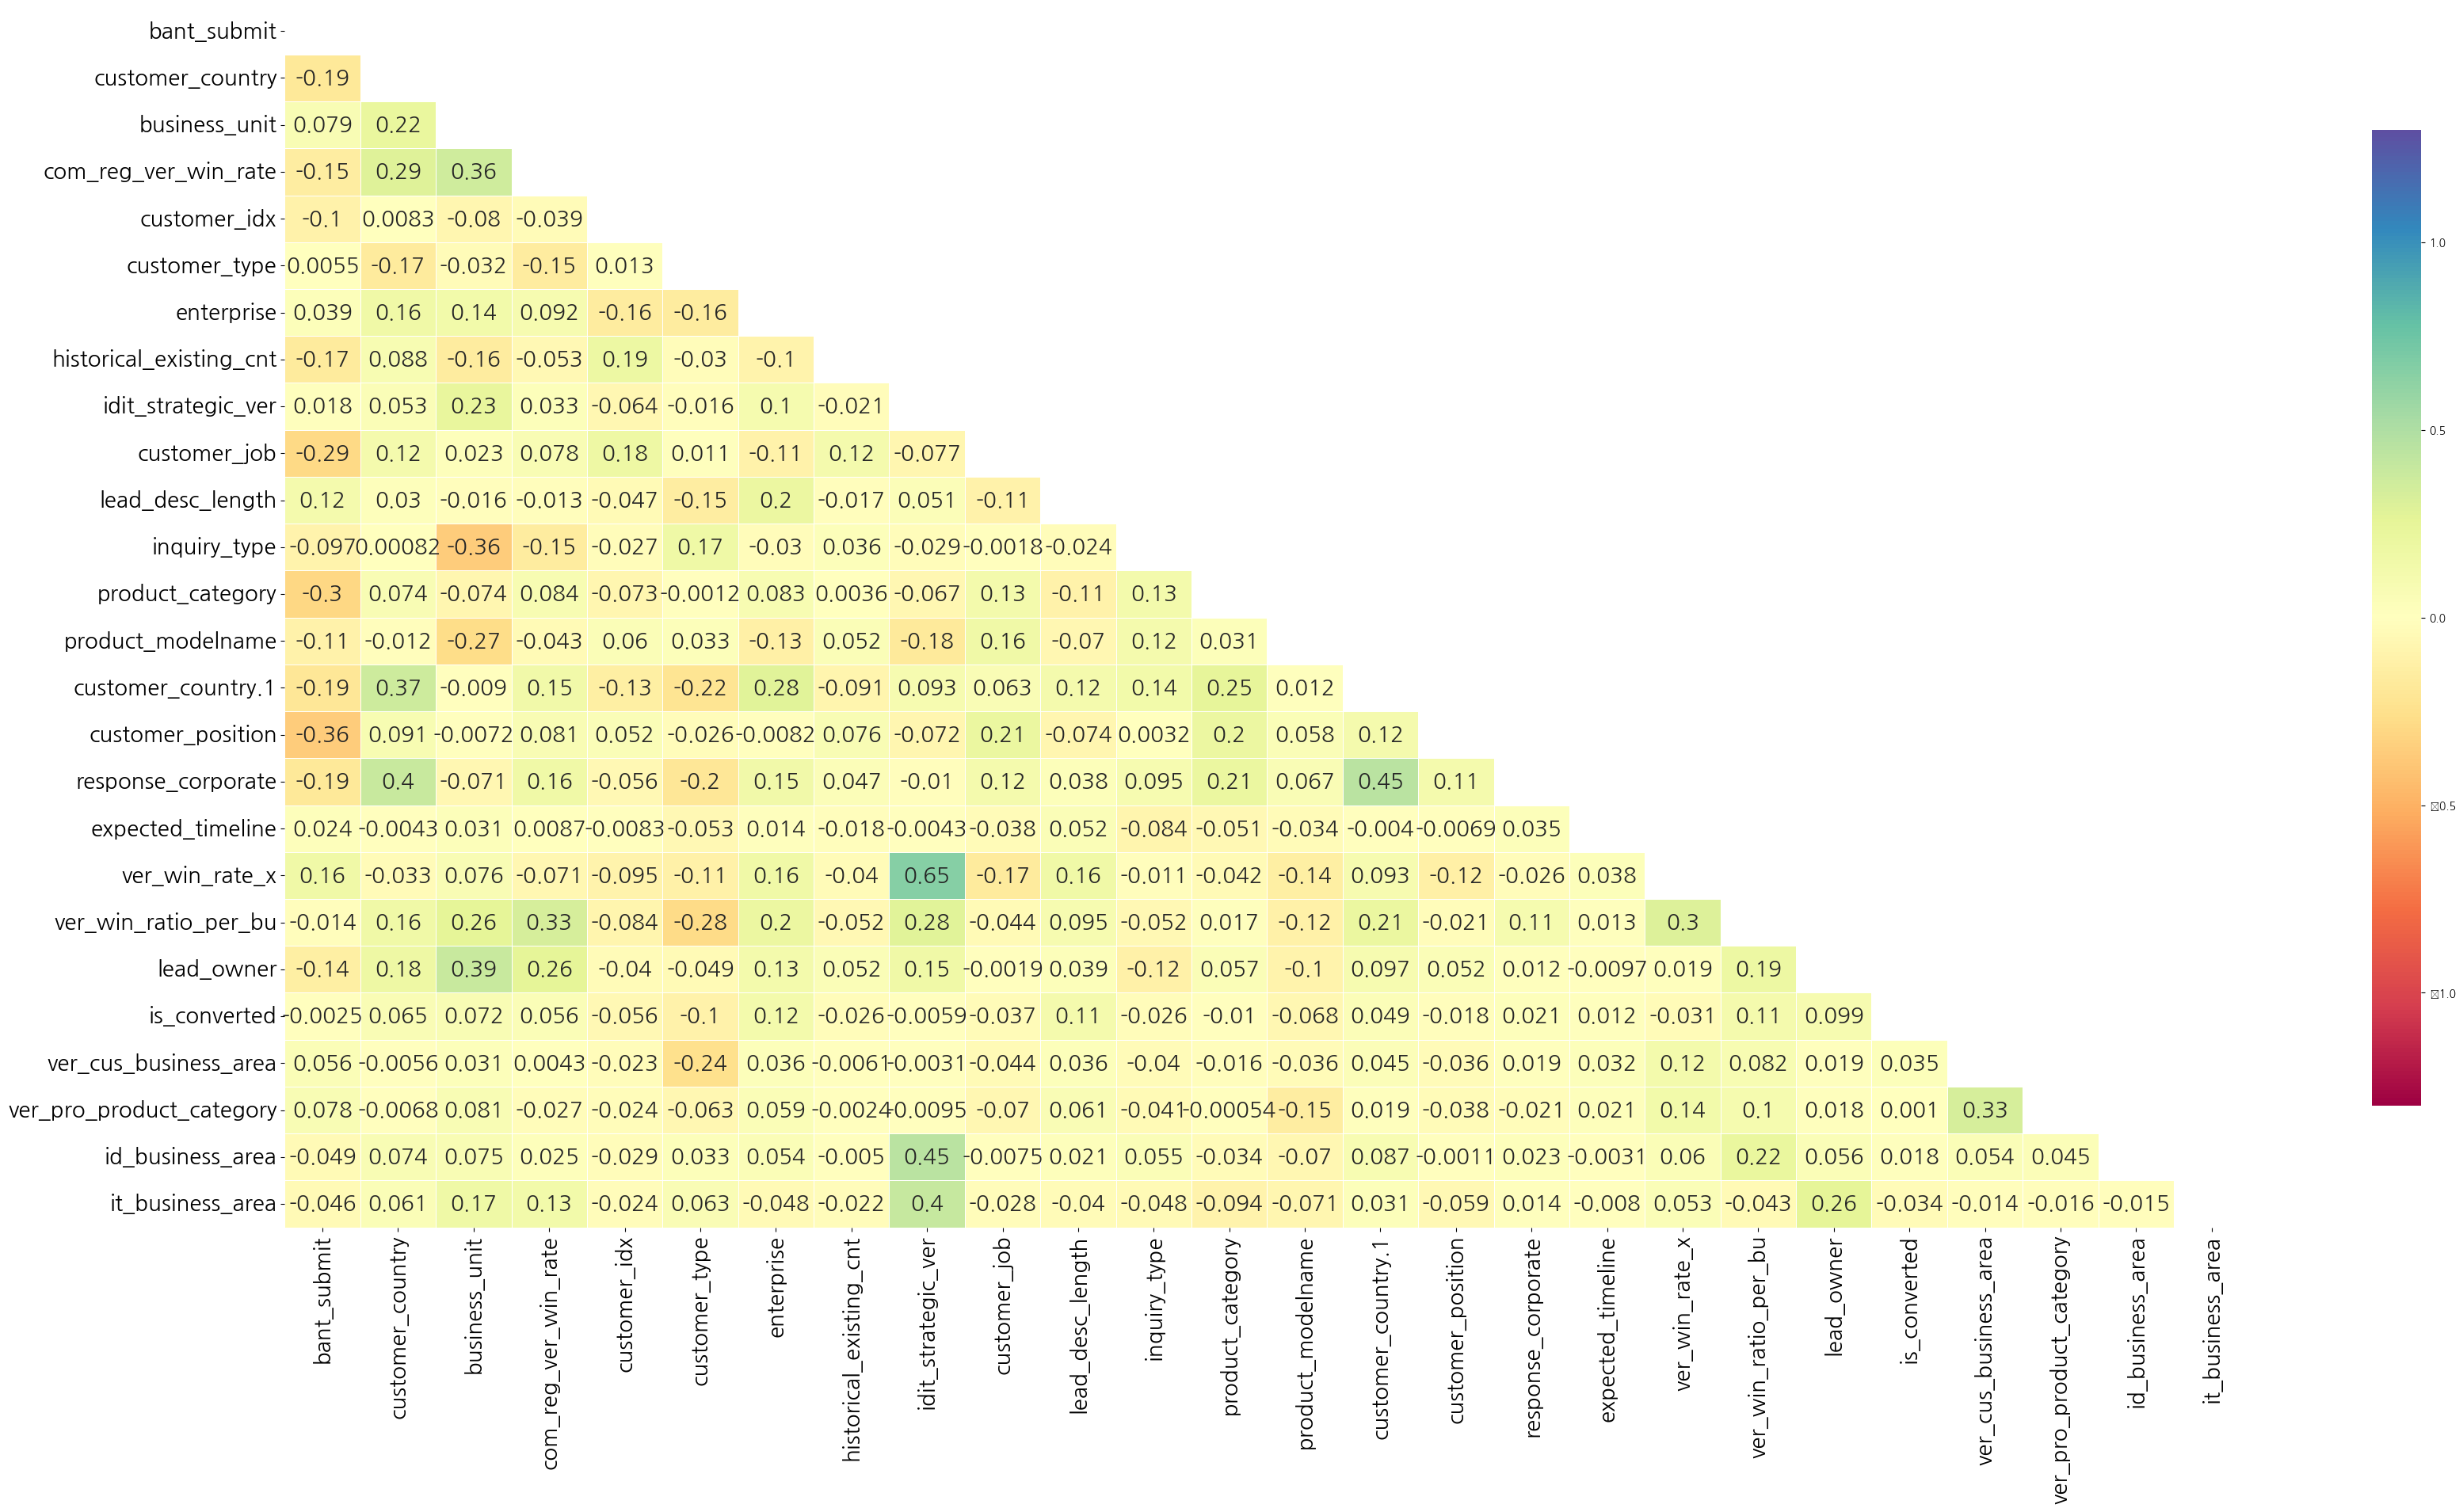

In [16]:
import numpy as np

# 숫자형 변수들 간의 상관관계 계산
corr = df_train_encoded.corr()

# 상관계수 행렬의 상삼각행렬을 마스킹하기 위한 마스크 생성
mask = np.triu(np.ones_like(corr, dtype=bool))

# 히트맵
plt.figure(figsize=(40, 20))

sns.heatmap(corr,
            mask=mask, # 마스크 적용
            annot=True, # 수치(상관관계) 표시
            annot_kws = {'size':20}, # 수치표시 사이즈
            cmap='Spectral', # 색상 변경
            vmin=-1.3, # 색상 팔레트 범위
            vmax=1.3,
            linewidths=.5, # 히트맵의 선 스타일 변경
            cbar_kws={"shrink": .8}) # 히트맵 주변에 색상 바 추가(사이즈 조절 가능)

# 변수 이름의 크기 조절
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     6.606944               bant_submit
1     6.055597          customer_country
2     3.929035             business_unit
3     1.967966      com_reg_ver_win_rate
4     4.635261              customer_idx
5     9.662913             customer_type
6     1.908098                enterprise
7     1.193335   historical_existing_cnt
8     4.638523        idit_strategic_ver
9     5.595488              customer_job
10    1.506572          lead_desc_length
11   14.102781              inquiry_type
12    7.423364          product_category
13   19.114994         product_modelname
14    3.679468        customer_country.1
15    5.590085         customer_position
16    8.480235        response_corporate
17    7.312441         expected_timeline
18    3.473619            ver_win_rate_x
19    1.765265      ver_win_ratio_per_bu
20    3.054505                lead_owner
21    1.236121     ver_cus_business_area
22    1.226519  ver_pro_product_category
23    1.859207  

In [18]:
df_train_encoded = df_train_encoded.drop(['product_modelname'], axis=1)
df_test_encoded = df_test_encoded.drop(['product_modelname'], axis=1)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     6.099111               bant_submit
1     6.029511          customer_country
2     3.894057             business_unit
3     1.964324      com_reg_ver_win_rate
4     4.538364              customer_idx
5     9.324238             customer_type
6     1.906043                enterprise
7     1.193329   historical_existing_cnt
8     4.617623        idit_strategic_ver
9     5.329541              customer_job
10    1.506218          lead_desc_length
11   13.284366              inquiry_type
12    7.331087          product_category
13    3.679465        customer_country.1
14    5.461265         customer_position
15    8.357659        response_corporate
16    7.120155         expected_timeline
17    3.468688            ver_win_rate_x
18    1.765120      ver_win_ratio_per_bu
19    3.040749                lead_owner
20    1.231642     ver_cus_business_area
21    1.210545  ver_pro_product_category
22    1.859207          id_business_area
23    1.746067  

In [20]:
df_train_encoded = df_train_encoded.drop(['inquiry_type'], axis=1)
df_test_encoded = df_test_encoded.drop(['inquiry_type'], axis=1)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 종속 변수와 독립 변수를 분리합니다.
y = df_train_encoded['is_converted']
X = df_train_encoded.drop(['is_converted'], axis=1)

# 각 독립 변수의 VIF를 계산합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

print(vif)

    VIF Factor                  features
0     5.707813               bant_submit
1     5.953934          customer_country
2     3.617232             business_unit
3     1.959600      com_reg_ver_win_rate
4     4.497226              customer_idx
5     7.862998             customer_type
6     1.905982                enterprise
7     1.193251   historical_existing_cnt
8     4.617459        idit_strategic_ver
9     5.290303              customer_job
10    1.504986          lead_desc_length
11    7.020601          product_category
12    3.636741        customer_country.1
13    5.400196         customer_position
14    8.249876        response_corporate
15    7.060164         expected_timeline
16    3.466590            ver_win_rate_x
17    1.751022      ver_win_ratio_per_bu
18    3.032822                lead_owner
19    1.227921     ver_cus_business_area
20    1.209600  ver_pro_product_category
21    1.856861          id_business_area
22    1.745582          it_business_area


### 최종적으로 선정된 변수

In [22]:
df_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bant_submit               59299 non-null  float64
 1   customer_country          59299 non-null  int32  
 2   business_unit             59299 non-null  int32  
 3   com_reg_ver_win_rate      59299 non-null  float64
 4   customer_idx              59299 non-null  int64  
 5   customer_type             59299 non-null  int32  
 6   enterprise                59299 non-null  int32  
 7   historical_existing_cnt   59299 non-null  float64
 8   idit_strategic_ver        59299 non-null  float64
 9   customer_job              59299 non-null  int32  
 10  lead_desc_length          59299 non-null  int64  
 11  product_category          59299 non-null  int32  
 12  customer_country.1        59299 non-null  int32  
 13  customer_position         59299 non-null  int32  
 14  respon

In [23]:
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5271 non-null   int64  
 1   bant_submit               5271 non-null   float64
 2   customer_country          5271 non-null   int32  
 3   business_unit             5271 non-null   int32  
 4   com_reg_ver_win_rate      5271 non-null   float64
 5   customer_idx              5271 non-null   int64  
 6   customer_type             5271 non-null   int32  
 7   enterprise                5271 non-null   int32  
 8   historical_existing_cnt   5271 non-null   float64
 9   idit_strategic_ver        5271 non-null   float64
 10  customer_job              5271 non-null   int32  
 11  lead_desc_length          5271 non-null   int64  
 12  product_category          5271 non-null   int32  
 13  customer_country.1        5271 non-null   int32  
 14  customer

In [24]:
df_train_encoded.to_csv('./data/Ch3/df_train_encoded.csv', index=False)
df_test_encoded.to_csv('./data/Ch3/df_test_encoded.csv', index=False)

.